In [567]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import (
    Binarizer,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    MaxAbsScaler,
)
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from scipy.stats import ttest_ind, ttest_1samp
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
import plotly.graph_objects as go

set_config(transform_output="pandas")

df = pd.read_csv("winequality-red.csv")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [568]:
df.isna().value_counts()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density  pH     sulphates  alcohol  quality
False          False             False        False           False      False                False                 False    False  False      False    False      1599
Name: count, dtype: int64

Aucune valeur manquante.

In [569]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

train_set

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
493,8.7,0.690,0.31,3.0,0.086,23.0,81.0,1.00020,3.48,0.74,11.6,6
354,6.1,0.210,0.40,1.4,0.066,40.5,165.0,0.99120,3.25,0.59,11.9,6
342,10.9,0.390,0.47,1.8,0.118,6.0,14.0,0.99820,3.30,0.75,9.8,6
834,8.8,0.685,0.26,1.6,0.088,16.0,23.0,0.99694,3.32,0.47,9.4,5
705,8.4,1.035,0.15,6.0,0.073,11.0,54.0,0.99900,3.37,0.49,9.9,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1130,9.1,0.600,0.00,1.9,0.058,5.0,10.0,0.99770,3.18,0.63,10.4,6
1294,8.2,0.635,0.10,2.1,0.073,25.0,60.0,0.99638,3.29,0.75,10.9,6
860,7.2,0.620,0.06,2.7,0.077,15.0,85.0,0.99746,3.51,0.54,9.5,5
1459,7.9,0.200,0.35,1.7,0.054,7.0,15.0,0.99458,3.32,0.80,11.9,7


Le but de ce projet est de prédire si un vin est considérée comme bon ou mauvais. La premiére étape est donc de binarisé la target en fonction d'un seuil logique. Le sueuil indiqué sur la description kaggle est de 6.5.

# I) Description des variables

1 - fixed acidity (g d’acide tartrique par dm³): la plupart des acides présents dans le vin sont fixes ou non volatils (ils ne s'évaporent pas facilement).

2 - volatile acidity (g d’acide acétique par dm³): la quantité d'acide acétique dans le vin, qui, à des niveaux trop élevés, peut donner un goût désagréable de vinaigre.

3 - citric acid (g par dm³): Présent en petites quantités, l'acide citrique peut ajouter de la « fraîcheur » et de la saveur aux vins.

4 - residual sugar (g par dm³): la quantité de sucre restante après l'arrêt de la fermentation, il est rare de trouver des vins contenant moins de 1 gramme/litre

5 - chlorides (g de chlorure de sodium par dm³): La quantité de sel dans le vin

6 - free sulfur dioxide (mg par dm³): La forme libre du SO2 existe en équilibre entre le SO2 moléculaire (sous forme de gaz dissous) et l'ion bisulfite.

7 - total sulfur dioxide (mg par dm³): quantité de formes libres et liées de S02 ; à faible concentration, le SO2 est généralement indétectable dans le vin

8 - density (g par cm³): La densité du vin est proche de celle de l'eau, en fonction du pourcentage d'alcool et de la teneur en sucre.

9 - pH : Décrit le degré d'acidité ou d'alcalinité d'un vin sur une échelle allant de 0 (très acide) à 14 (très alcalin)

10 - sulphates (g de sulfate de potassium par dm³): un additif pour le vin qui peut contribuer à augmenter les niveaux de dioxyde de soufre (SO2), qui agit comme antimicrobien et antioxydant.

11 - alcohol (pourcentage volumique, % vol): Le degrés d'alcool du vin.

Output variable (based on sensory data):

12 - quality (score between 0 and 10)

La target quality est la seule variable discréte de ce jeu de données.
Les lignes sont différents vin.

La premiére chose à faire est de binarisé la target avec un seuil de 6.5 en dessous de laquelle il y aurat la valeur 0 et au-dessus la valeur 1.

In [570]:
target_binarizer = ColumnTransformer(
    [("Target binarizer", Binarizer(threshold=6.5), ["quality"])],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

train_set_binarisé = target_binarizer.fit_transform(train_set)
train_set_binarisé

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
493,0,8.7,0.690,0.31,3.0,0.086,23.0,81.0,1.00020,3.48,0.74,11.6
354,0,6.1,0.210,0.40,1.4,0.066,40.5,165.0,0.99120,3.25,0.59,11.9
342,0,10.9,0.390,0.47,1.8,0.118,6.0,14.0,0.99820,3.30,0.75,9.8
834,0,8.8,0.685,0.26,1.6,0.088,16.0,23.0,0.99694,3.32,0.47,9.4
705,0,8.4,1.035,0.15,6.0,0.073,11.0,54.0,0.99900,3.37,0.49,9.9
...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0,9.1,0.600,0.00,1.9,0.058,5.0,10.0,0.99770,3.18,0.63,10.4
1294,0,8.2,0.635,0.10,2.1,0.073,25.0,60.0,0.99638,3.29,0.75,10.9
860,0,7.2,0.620,0.06,2.7,0.077,15.0,85.0,0.99746,3.51,0.54,9.5
1459,1,7.9,0.200,0.35,1.7,0.054,7.0,15.0,0.99458,3.32,0.80,11.9


# II) Analyse statistiques

## II.1) Analyse de la target

In [571]:
train_set_binarisé["quality"].value_counts()

quality
0    1109
1     170
Name: count, dtype: int64

On voit que la plupart des vins sont mauvais et seulement 170 vin sont considéré comme bon. On observe que les deux classes de la target sont trés déséquilibré et donc on choisira le score f1.

## II.2) L'acidité fixe

### II.2.1) Analyse univarié

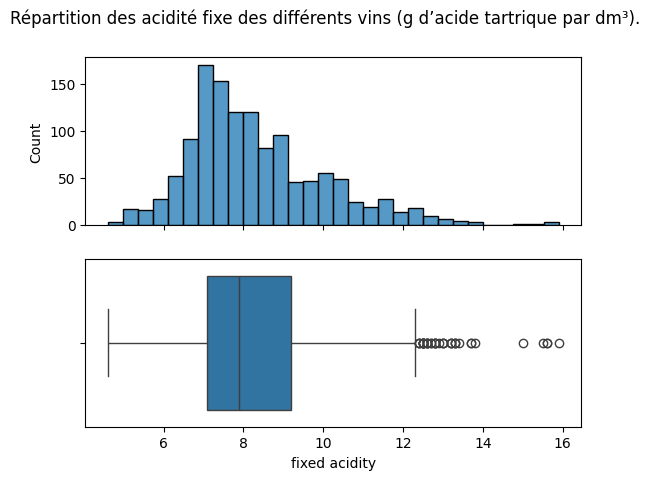

count    1279.000000
mean        8.323690
std         1.724243
min         4.600000
25%         7.100000
50%         7.900000
75%         9.200000
max        15.900000
Name: fixed acidity, dtype: float64

In [572]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle(
    "Répartition des acidité fixe des différents vins (g d’acide tartrique par dm³)."
)
sns.histplot(data=train_set_binarisé, x="fixed acidity", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="fixed acidity", ax=ax[1])
plt.show()

train_set_binarisé["fixed acidity"].describe()

On voit que l'acidité fixe suit une belle loi normale et que la plupart des acidités fixe sont entre 6 et 10. La moyenne des acididté fixe des vins de ce jeu de données est de 8.323690 g d’acide tartrique par dm³ avec un écart-type de 1.724243 g d’acide tartrique par dm³. Le minimum est de 4.6 g d’acide tartrique par dm³ et le maximum est de 15.9 g d’acide tartrique par dm³. On observe aussi des oultiers à droite de la boxplot.

### II.2.2) Analyse multivarié

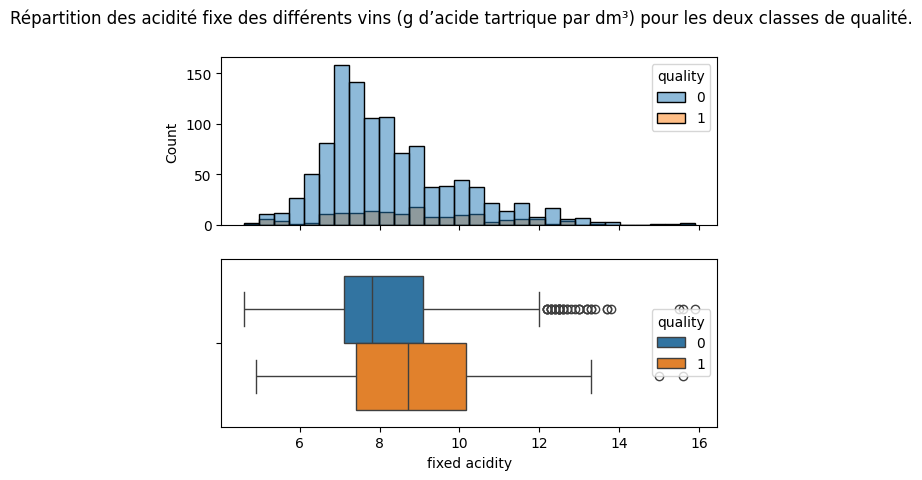

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
0,1109.0,8.245446,1.669154,4.6,7.1,7.8,9.100,15.9
1,170.0,8.834118,1.978377,4.9,7.4,8.7,10.175,15.6


In [573]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle(
    "Répartition des acidité fixe des différents vins (g d’acide tartrique par dm³) pour les deux classes de qualité."
)
sns.histplot(data=train_set_binarisé, x="fixed acidity", hue="quality", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="fixed acidity", hue="quality", ax=ax[1])
plt.show()

train_set_binarisé.groupby("quality")["fixed acidity"].describe()

On observe une superposition totale des deux classes de la target sur l'histogramme mais les boxplots sont légéremnt diffférents. Les moyennes d'acidité fixe est légérement supérieur pour les bons vin, on va donc tester avec un test de student cette différence. Vérifions tous d'abords les conditions d'utilisation: 

1) Tous les vins sont des vins de type "vihno verde" 

2) L'acidité fixe d'un vin ne dépends des autres 

3) Il y a bien plus de 3à points par classes

4) Les deux écart-types sont bien assez similaires pour utiliser un test de student.

In [574]:
print(
    "H0: L'acidité fixe des bon vin est en moyenne identique à ceux des mauvais vins."
)

alpha = 0.02

p_value = ttest_ind(
    train_set_binarisé.query("`quality` == 1")["fixed acidity"],
    train_set_binarisé.query("`quality` == 0")["fixed acidity"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidences pour rejeter H0.")

H0: L'acidité fixe des bon vin est en moyenne identique à ceux des mauvais vins.
Nous avons assez d'évidence pour rejeter H0.


Malgré une superposition des deux classes de la target, on a réussie à rejeter H0 ce qui indique qu'il y a bien une différences statistiques entre les deux moyennes. On peut donc dire que l'acidité fixe améliore légérement la qualité du vin.

## II.3) Acidité volatile

### II.3.1) Analyse univarié

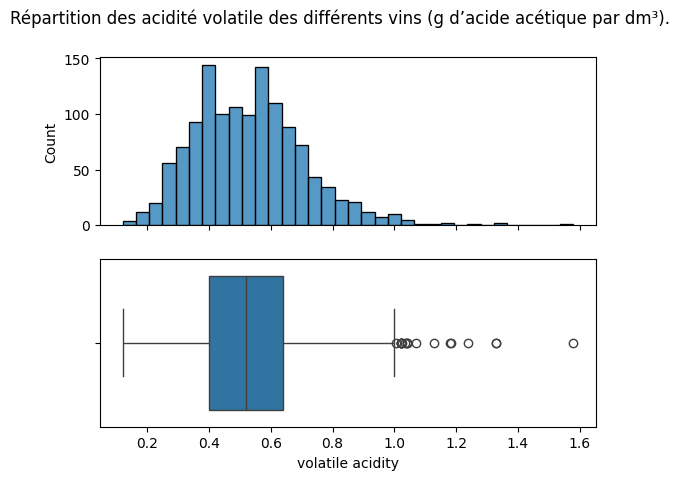

count    1279.000000
mean        0.530559
std         0.179275
min         0.120000
25%         0.400000
50%         0.520000
75%         0.640000
max         1.580000
Name: volatile acidity, dtype: float64

In [575]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle(
    "Répartition des acidité volatile des différents vins (g d’acide acétique par dm³)."
)
sns.histplot(data=train_set_binarisé, x="volatile acidity", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="volatile acidity", ax=ax[1])
plt.show()

train_set_binarisé["volatile acidity"].describe()

La moyenne d'acidité volatile des vins de ce jeu de donnée est de 0.530559 g d’acide acétique par dm³ avec une écart-type de 0.179275 g d’acide acétique par dm³. On observe que l'acidité volatile suit une loi normale. On observe des outliers à droite de la boxplot. La plupart de ces acidité sont entre 0.3 et 0.7.

### II.3.2) Analyse multivarié

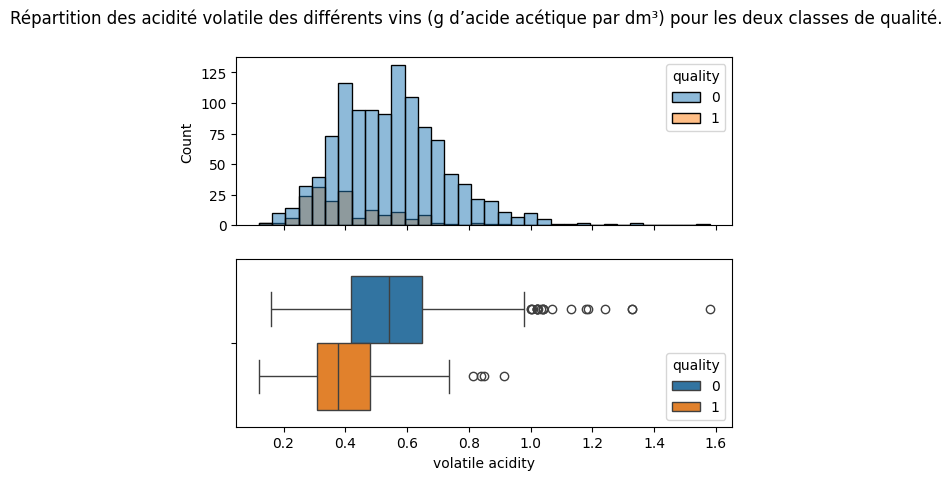

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
0,1109.0,0.54927,0.176834,0.16,0.42,0.540,0.65,1.580
1,170.0,0.40850,0.144032,0.12,0.31,0.375,0.48,0.915


In [576]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle(
    "Répartition des acidité volatile des différents vins (g d’acide acétique par dm³) pour les deux classes de qualité."
)
sns.histplot(data=train_set_binarisé, x="volatile acidity", hue="quality", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="volatile acidity", hue="quality", ax=ax[1])
plt.show()

train_set_binarisé.groupby("quality")["volatile acidity"].describe()

On voit que les deux classes sont superposé mais que les bon vins sont principalement entre 0 et 0.8. On voit aussi cette différence sur les boxplots. Cette variable est donc plus intéréssante que l'acidité fixe. Sans surprise les bons vin ont en moyenne une plus petite acidité volatile que les mauvais car cette acidité donne un gout de vinaigre. Faisons un test de student. L'acidité volatile d'un vin ne dépends des autres.

In [577]:
print(
    "H0: L'acidité volatile des bon vin est en moyenne identique à ceux des mauvais vins."
)

alpha = 0.02

p_value = ttest_ind(
    train_set_binarisé.query("`quality` == 1")["volatile acidity"],
    train_set_binarisé.query("`quality` == 0")["volatile acidity"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidences pour rejeter H0.")

H0: L'acidité volatile des bon vin est en moyenne identique à ceux des mauvais vins.
Nous avons assez d'évidence pour rejeter H0.


Comme l'hypothése H0, à été rejeter, on peut dire que les bon vin ont bien une acidité volatile moins élevé que les mauvais vin.

## II.4) Acide citrique

### II.4.1) Analyse univarié

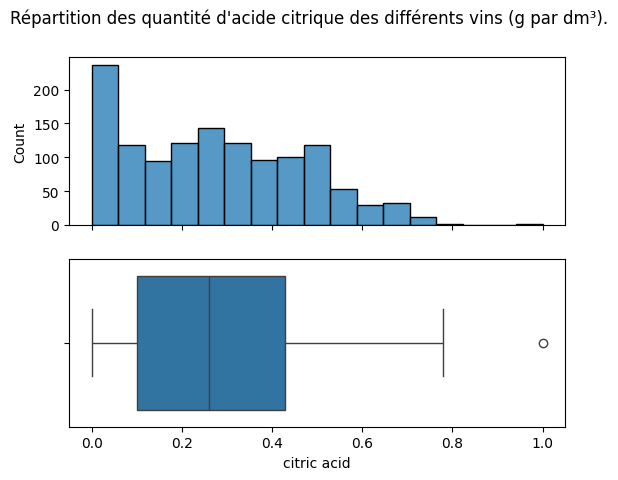

count    1279.000000
mean        0.272471
std         0.195448
min         0.000000
25%         0.100000
50%         0.260000
75%         0.430000
max         1.000000
Name: citric acid, dtype: float64

In [578]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle(
    "Répartition des quantité d'acide citrique des différents vins (g par dm³)."
)
sns.histplot(data=train_set_binarisé, x="citric acid", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="citric acid", ax=ax[1])
plt.show()

train_set_binarisé["citric acid"].describe()

Les vins de ce jeu de données ont en moyenne 0.272471 g/dm3 d'acide citrique. On voit que cette variable ne suit pas une loi normale et un seul outliers est présent sur la boxplot à 1 g/dm3. La majorité des vins ont entre 0 et 0.6 g/dm3 d'acide citrique.

### II.4.2) Analyse multivarié

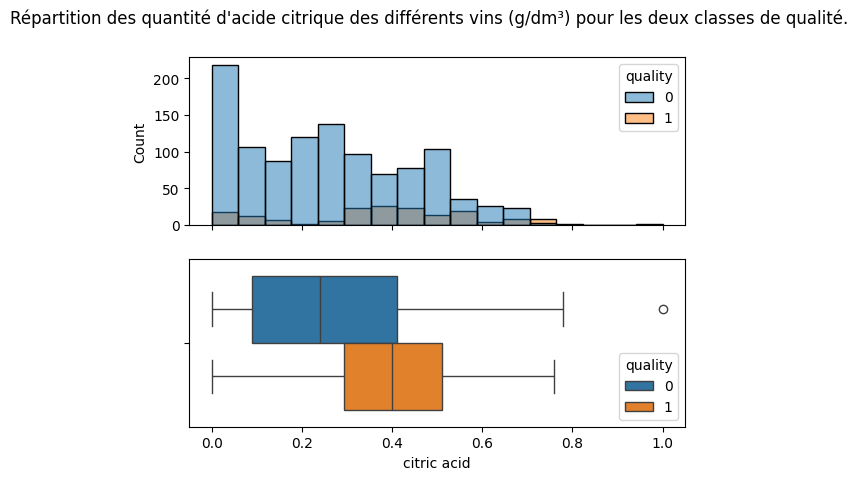

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
0,1109.0,0.256682,0.189697,0.0,0.0900,0.24,0.41,1.00
1,170.0,0.375471,0.201591,0.0,0.2925,0.40,0.51,0.76


In [579]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle(
    "Répartition des quantité d'acide citrique des différents vins (g/dm³) pour les deux classes de qualité."
)
sns.histplot(data=train_set_binarisé, x="citric acid", hue="quality", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="citric acid", hue="quality", ax=ax[1])
plt.show()

train_set_binarisé.groupby("quality")["citric acid"].describe()

On voit une superposition des deux classes de la target et des boxplot et comme cette variable ne suit pas une loi normale, on va tester la différence avec un test de de student.

In [580]:
print(
    "H0: La quantité d'acide citrique des bon vin est en moyenne identique à ceux des mauvais vins."
)

alpha = 0.02

p_value = ttest_ind(
    train_set_binarisé.query("`quality` == 1")["citric acid"],
    train_set_binarisé.query("`quality` == 0")["citric acid"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidences pour rejeter H0.")

H0: La quantité d'acide citrique des bon vin est en moyenne identique à ceux des mauvais vins.
Nous avons assez d'évidence pour rejeter H0.


Comme on a rejeter H0, on peut donc dire qu'il y a bien une différence entre les deux moyenne.

## II.5) Le sucre résiduel

### II.5.1) Analyse univarié

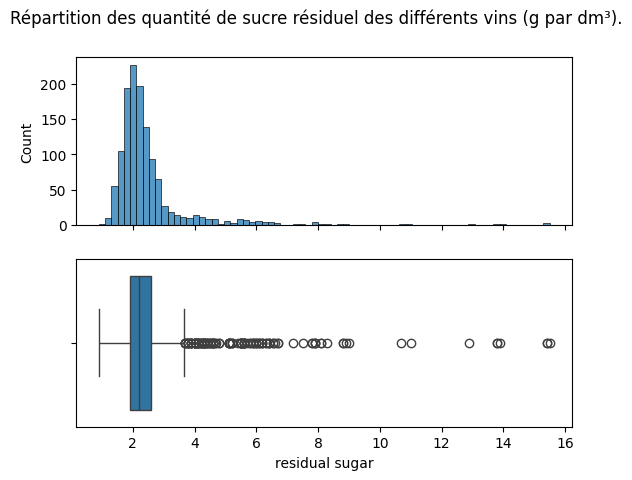

count    1279.000000
mean        2.555473
std         1.435790
min         0.900000
25%         1.900000
50%         2.200000
75%         2.600000
max        15.500000
Name: residual sugar, dtype: float64

In [581]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle(
    "Répartition des quantité de sucre résiduel des différents vins (g par dm³)."
)
sns.histplot(data=train_set_binarisé, x="residual sugar", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="residual sugar", ax=ax[1])
plt.show()

train_set_binarisé["residual sugar"].describe()

Les vins de ce jeu de donnée ont en moyenne 2.555473 g/dm3 de sucre résiduel. On observe une loi normale écraser par une multitude de valeurs abbérantes. La plupart des vins ont entre 2 et 2.5 g/dm3.

### II.5.2) Analyse mutlivarié

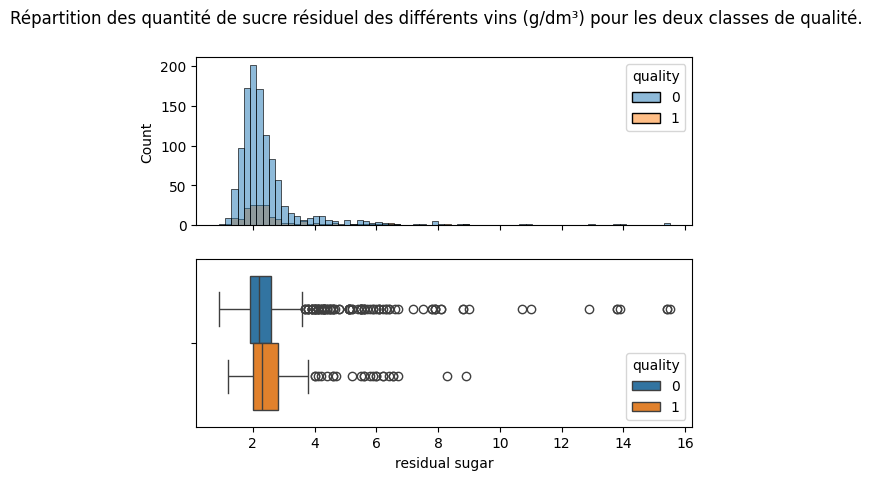

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
0,1109.0,2.526555,1.444875,0.9,1.9,2.2,2.6,15.5
1,170.0,2.744118,1.364120,1.2,2.0,2.3,2.8,8.9


In [582]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle(
    "Répartition des quantité de sucre résiduel des différents vins (g/dm³) pour les deux classes de qualité."
)
sns.histplot(data=train_set_binarisé, x="residual sugar", hue="quality", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="residual sugar", hue="quality", ax=ax[1])
plt.show()

train_set_binarisé.groupby("quality")["residual sugar"].describe()

On observe une superposition totale des deux classes avec trés peu de différences entre les moyennes et les boxplots. Les bon vins ont en moyenne une quantité de sucre résiduel légérement supérieur à ceux des mauvais vins. 

In [583]:
print(
    "H0: La quantité de sucre résiduel des bons vins est en moyenne identique à ceux des mauvais vins."
)

alpha = 0.02

p_value = ttest_ind(
    train_set_binarisé.query("`quality` == 1")["residual sugar"],
    train_set_binarisé.query("`quality` == 0")["residual sugar"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidences pour rejeter H0.")

H0: La quantité de sucre résiduel des bons vins est en moyenne identique à ceux des mauvais vins.
Nous n'avons pas assez d'évidences pour rejeter H0.


Sans surprise l'hypothése H0 n'a pas été rejeter et donc on ne va pas prendre cette variable pour le modéle.

## II.6) chlorure

### II.6.1) Analyse univarié

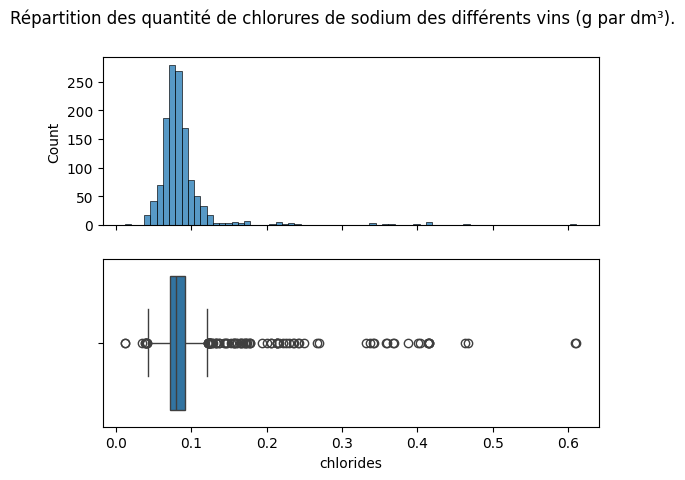

count    1279.000000
mean        0.088448
std         0.049332
min         0.012000
25%         0.071000
50%         0.080000
75%         0.091000
max         0.611000
Name: chlorides, dtype: float64

In [584]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle(
    "Répartition des quantité de chlorures de sodium des différents vins (g par dm³)."
)
sns.histplot(data=train_set_binarisé, x="chlorides", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="chlorides", ax=ax[1])
plt.show()

train_set_binarisé["chlorides"].describe()

Les vins de ce dataset ont en moyenne 0.088448 g/dm3 de chlorure de sodium. On observe une loi normale écraser par des valeurs abbérantes. La plupart des vins ont e,tre 0.05 et 0.1 g/dm3 de chlorure de sodium.

### II.6.2) Analyse multivarié

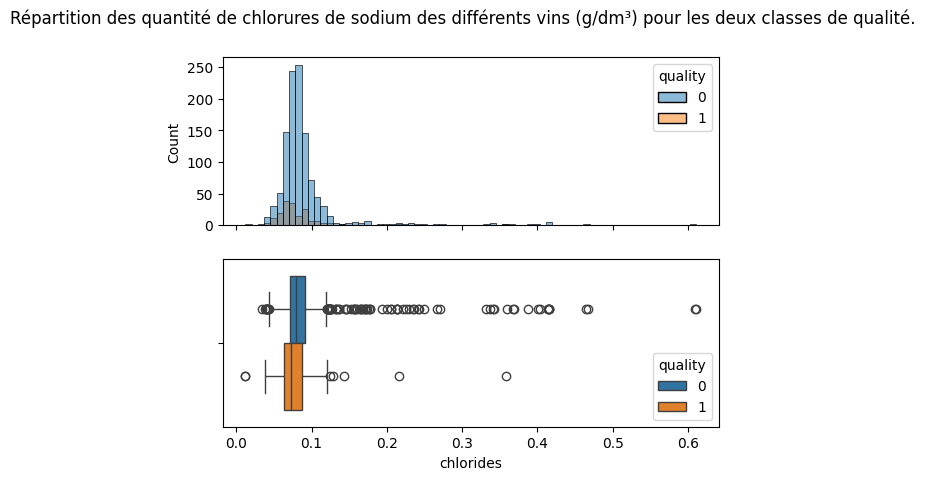

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
0,1109.0,0.090179,0.051354,0.034,0.072,0.0800,0.091,0.611
1,170.0,0.077159,0.031078,0.012,0.063,0.0725,0.087,0.358


In [585]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle(
    "Répartition des quantité de chlorures de sodium des différents vins (g/dm³) pour les deux classes de qualité."
)
sns.histplot(data=train_set_binarisé, x="chlorides", hue="quality", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="chlorides", hue="quality", ax=ax[1])
plt.show()

train_set_binarisé.groupby("quality")["chlorides"].describe()

On observe une superposition des deux classes de la target et une trés faible différences entre les moyennes et les boxplots. Les bons vins ont en moyenne moins de chlorure de sodium que les mauvais. Faisont le teste de student. On voit peu d'outlier pour les bon vin et beuacoup pour les mauvais.

In [586]:
print(
    "H0: La quantité de chlorures de sodium des bons vins est en moyenne identique à ceux des mauvais vins."
)

alpha = 0.02

p_value = ttest_ind(
    train_set_binarisé.query("`quality` == 1")["chlorides"],
    train_set_binarisé.query("`quality` == 0")["chlorides"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidences pour rejeter H0.")

H0: La quantité de chlorures de sodium des bons vins est en moyenne identique à ceux des mauvais vins.
Nous avons assez d'évidence pour rejeter H0.


Comme on a rejeter H0, on peut dire que les bon vin ont en moyenne moins de sel que les mauvais.

## II.7) SO2 libre

### II.7.1) Analyse univarié

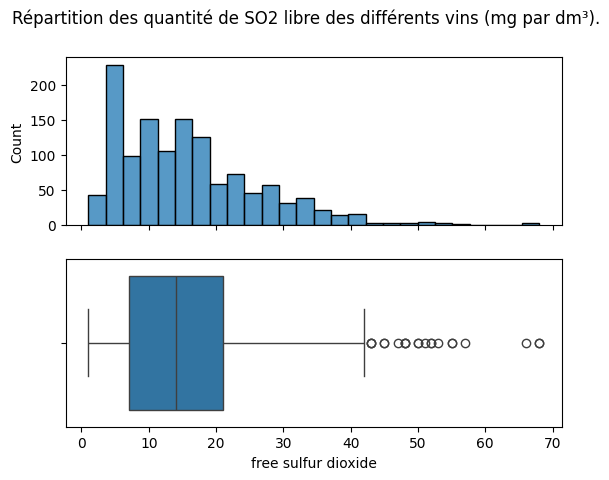

count    1279.000000
mean       15.876075
std        10.313517
min         1.000000
25%         7.000000
50%        14.000000
75%        21.000000
max        68.000000
Name: free sulfur dioxide, dtype: float64

In [587]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartition des quantité de SO2 libre des différents vins (mg par dm³).")
sns.histplot(data=train_set_binarisé, x="free sulfur dioxide", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="free sulfur dioxide", ax=ax[1])
plt.show()

train_set_binarisé["free sulfur dioxide"].describe()

Les vins de ce jeu de données ont en moyenne 15.876075 mg/dm3 de SO2 libre. Cette variable à une distribution qui peut être considéré comme normale même si la distribution n'est pas totalement centré. On observe des outliers à droite de la boxplot.

### II.7.2) Analyse multivarié

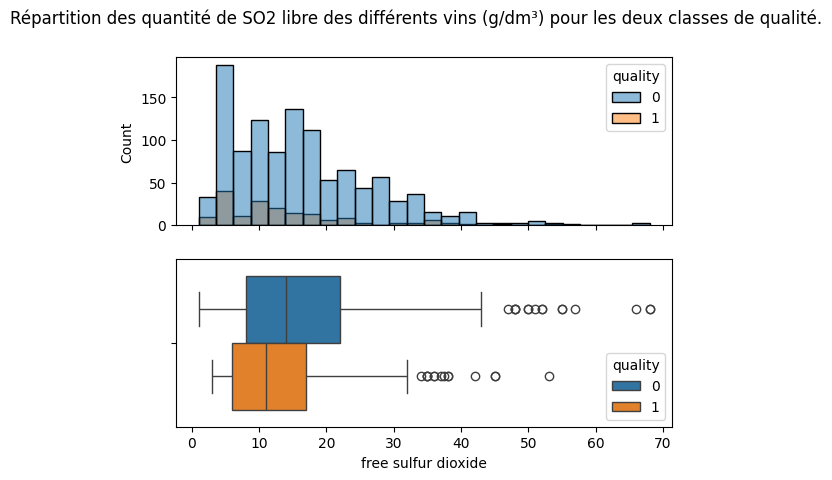

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
0,1109.0,16.207394,10.323853,1.0,8.0,14.0,22.0,68.0
1,170.0,13.714706,10.008994,3.0,6.0,11.0,17.0,53.0


In [588]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle(
    "Répartition des quantité de SO2 libre des différents vins (g/dm³) pour les deux classes de qualité."
)
sns.histplot(data=train_set_binarisé, x="free sulfur dioxide", hue="quality", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="free sulfur dioxide", hue="quality", ax=ax[1])
plt.show()

train_set_binarisé.groupby("quality")["free sulfur dioxide"].describe()

Comme pour les autres variables on observe que les deux classes sont superposé mais les boxplots sont différents. On observe que les bons vin ont en moyenne moins de SO2 que les mauvais vins. On voit que cette différences est assez grand. On observe que les bon vins sont principalement entre 0 et 30 mg/dm3.

In [589]:
print(
    "H0: La quantité de SO2 libre des bons vins est en moyenne identique à ceux des mauvais vins."
)

alpha = 0.02

p_value = ttest_ind(
    train_set_binarisé.query("`quality` == 1")["free sulfur dioxide"],
    train_set_binarisé.query("`quality` == 0")["free sulfur dioxide"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidences pour rejeter H0.")

H0: La quantité de SO2 libre des bons vins est en moyenne identique à ceux des mauvais vins.
Nous avons assez d'évidence pour rejeter H0.


Comme on a rejeter H0, on peut dire que les bon vin ont en moyenne moins de SO2 libre que les mauvais.

## II.8) SO2 total

### II.8.1) Analyse univarié

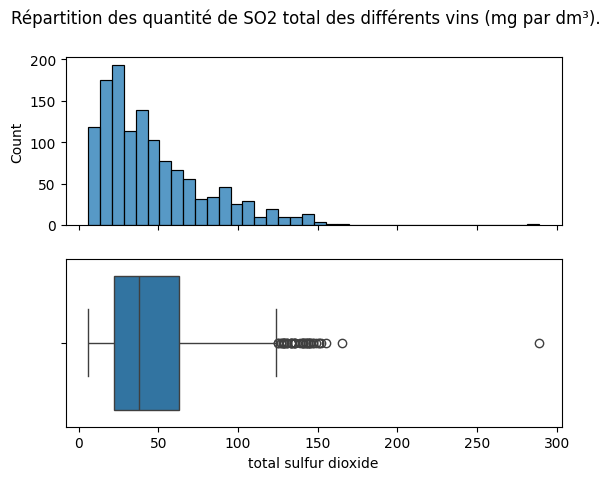

count    1279.000000
mean       46.657154
std        32.941962
min         6.000000
25%        22.000000
50%        38.000000
75%        63.000000
max       289.000000
Name: total sulfur dioxide, dtype: float64

In [590]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartition des quantité de SO2 total des différents vins (mg par dm³).")
sns.histplot(data=train_set_binarisé, x="total sulfur dioxide", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="total sulfur dioxide", ax=ax[1])
plt.show()

train_set_binarisé["total sulfur dioxide"].describe()

Les vins de ce dataset ont en moyenne 46.657154 mg/dm3 de S02 total. On voit qu'il y a un outlier trés éloigné à plus de 250 mg/dm3. La distribution de cette variable n'est pas normale.

### II.8.2) Analyse multivarié

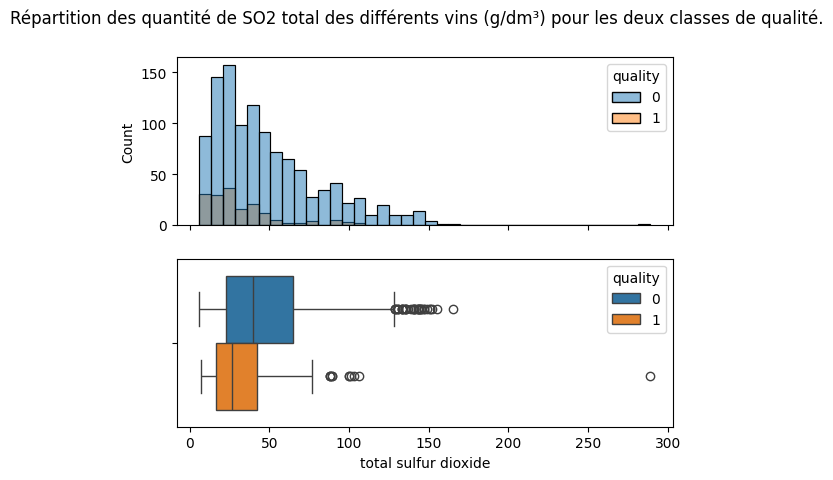

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
0,1109.0,48.649684,32.994245,6.0,23.00,40.0,65.0,165.0
1,170.0,33.658824,29.546294,7.0,16.25,26.5,42.0,289.0


In [591]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle(
    "Répartition des quantité de SO2 total des différents vins (g/dm³) pour les deux classes de qualité."
)
sns.histplot(data=train_set_binarisé, x="total sulfur dioxide", hue="quality", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="total sulfur dioxide", hue="quality", ax=ax[1])
plt.show()

train_set_binarisé.groupby("quality")["total sulfur dioxide"].describe()

On observe une superposition des deux classes de la target mais les boxplots sont différents. On voit que les bons vins ont un intervalle plus petit que pour les mauvais. Ont voit que les bon vin ont en moyenne moins de SO2 totale que les mauvais.

In [592]:
print(
    "H0: La quantité totale de SO2 des bon vin est en moyenne identique à ceux des mauvais vins."
)

alpha = 0.02

p_value = ttest_ind(
    train_set_binarisé.query("`quality` == 1")["total sulfur dioxide"],
    train_set_binarisé.query("`quality` == 0")["total sulfur dioxide"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidences pour rejeter H0.")

H0: La quantité totale de SO2 des bon vin est en moyenne identique à ceux des mauvais vins.
Nous avons assez d'évidence pour rejeter H0.


Comme on a rejeter H0, on peut dire qu'il y a des différence entre les deux moyennes.

## II.9) Densité

### II.9.1) Analyse univarié

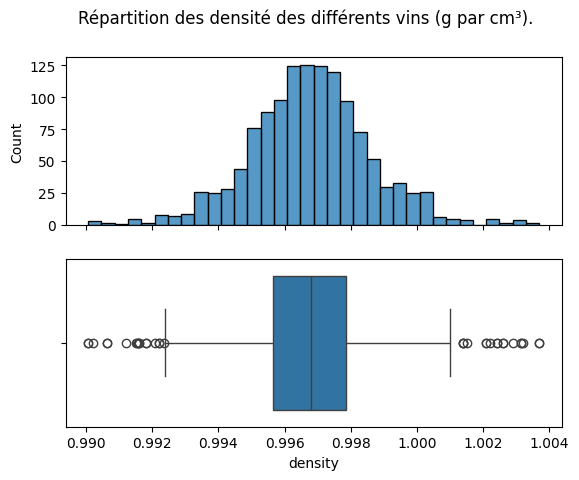

count    1279.000000
mean        0.996774
std         0.001856
min         0.990070
25%         0.995655
50%         0.996800
75%         0.997845
max         1.003690
Name: density, dtype: float64

In [593]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartition des densité des différents vins (g par cm³).")
sns.histplot(data=train_set_binarisé, x="density", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="density", ax=ax[1])
plt.show()

train_set_binarisé["density"].describe()

Les vins de ce dataset ont en moyenne une densité de 0.996774 g/cm3 ce qui est proche de la densité de l'eau de 0.997 g/cm3. On observe que la densité suit une belle loi normale avec des outliers à gauche et à droite de la boxplots. Vérifions si les vins de ce jeu ont en moyenne une densité égale à l'eau.

In [594]:
print("Les vins de ce jeu de données ont en moyenne la même densité que l'eau.")

alpha = 0.02

p_value = ttest_1samp(train_set_binarisé["density"], popmean=0.997).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidences pour rejeter H0.")

Les vins de ce jeu de données ont en moyenne la même densité que l'eau.
Nous avons assez d'évidence pour rejeter H0.


Comme on a rejeter H0, on peut dire que les vins ont en moyenne une densité différente de celle de l'eau.

### II.9.2) Analyse mutlivarié

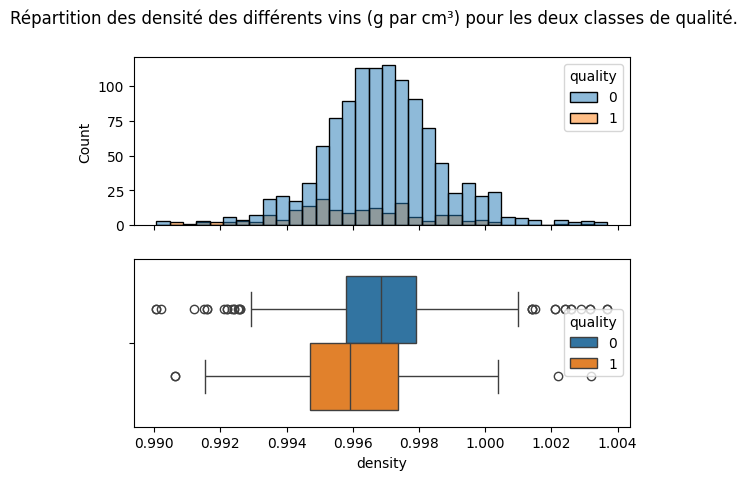

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
0,1109.0,0.996882,0.001786,0.99007,0.9958,0.99685,0.99790,1.00369
1,170.0,0.996072,0.002135,0.99064,0.9947,0.99593,0.99736,1.00320


In [595]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle(
    "Répartition des densité des différents vins (g par cm³) pour les deux classes de qualité."
)
sns.histplot(data=train_set_binarisé, x="density", hue="quality", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="density", hue="quality", ax=ax[1])
plt.show()

train_set_binarisé.groupby("quality")["density"].describe()

On observe toujours une superposition des deux classes de la target mais on observe des différences dans les boxplots. Par contre les moyennes sont vraiment trés similaires.

In [596]:
print("H0: La densité des bons vins est en moyenne identique à ceux des mauvais vins.")

alpha = 0.02

p_value = ttest_ind(
    train_set_binarisé.query("`quality` == 1")["density"],
    train_set_binarisé.query("`quality` == 0")["density"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidences pour rejeter H0.")

H0: La densité des bons vins est en moyenne identique à ceux des mauvais vins.
Nous avons assez d'évidence pour rejeter H0.


Malgré une grande similarité des moyennes entre les deux types de vin, l'hypothése à été rejeter et par conséquent on garde cette variable.

## II.10) pH

### II.10.1) Analyse univarié

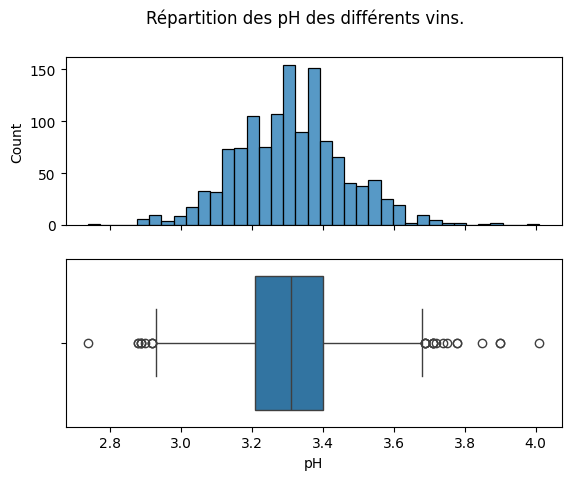

count    1279.000000
mean        3.311650
std         0.154016
min         2.740000
25%         3.210000
50%         3.310000
75%         3.400000
max         4.010000
Name: pH, dtype: float64

In [597]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartition des pH des différents vins.")
sns.histplot(data=train_set_binarisé, x="pH", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="pH", ax=ax[1])
plt.show()

train_set_binarisé["pH"].describe()

Les vins de ce jeu de données ont en moyenne un pH de 3.311650 et donc ils sont en moyenne acide. Le pH suit une loi normale et on observe des outliers à gauche et à ddroite de la boxplot.

### II.10.2) Analyse multivarié

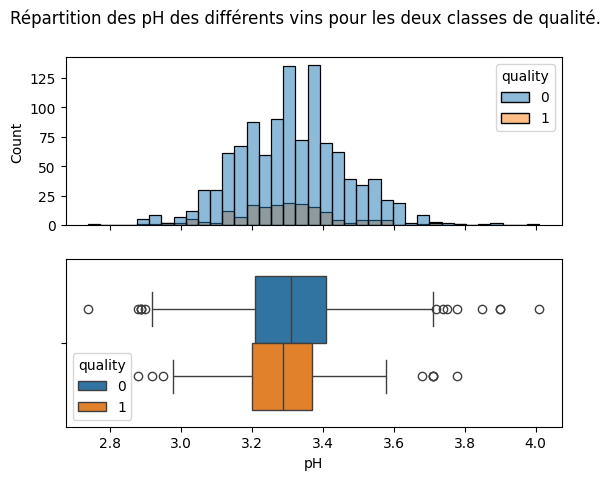

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
0,1109.0,3.314626,0.153927,2.74,3.2100,3.31,3.41,4.01
1,170.0,3.292235,0.153634,2.88,3.2025,3.29,3.37,3.78


In [598]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartition des pH des différents vins pour les deux classes de qualité.")
sns.histplot(data=train_set_binarisé, x="pH", hue="quality", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="pH", hue="quality", ax=ax[1])
plt.show()

train_set_binarisé.groupby("quality")["pH"].describe()

On voit qu'il y a superposition des deux classes de la target et qu'il n'y a pas de grosse différences dans les boxplots et moyennes.

In [599]:
print("H0: Le pH des bons vins est en moyenne identique à ceux des mauvais vins.")

alpha = 0.02

p_value = ttest_ind(
    train_set_binarisé.query("`quality` == 1")["pH"],
    train_set_binarisé.query("`quality` == 0")["pH"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidences pour rejeter H0.")

H0: Le pH des bons vins est en moyenne identique à ceux des mauvais vins.
Nous n'avons pas assez d'évidences pour rejeter H0.


Comme on n'a pas réussie à rejeter H0, il n' y a pas de différences de moyenne de pH entre les deux classes. On ne prendra donc pas le pH pour notre modéle.

## II.11) Sulphates

### II.11.1) Analyse univarié

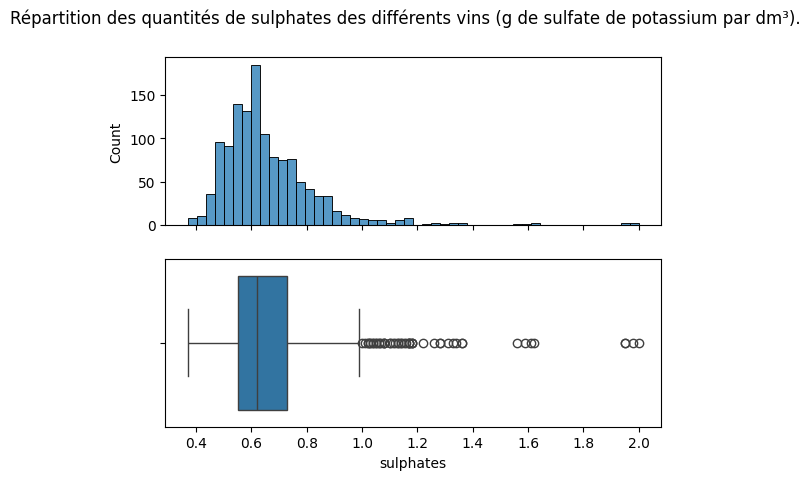

count    1279.000000
mean        0.660023
std         0.174605
min         0.370000
25%         0.550000
50%         0.620000
75%         0.730000
max         2.000000
Name: sulphates, dtype: float64

In [600]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle(
    "Répartition des quantités de sulphates des différents vins (g de sulfate de potassium par dm³)."
)
sns.histplot(data=train_set_binarisé, x="sulphates", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="sulphates", ax=ax[1])
plt.show()

train_set_binarisé["sulphates"].describe()

Les vins de ce jeu de données ont en moyenne 0.660023 g de sulfate de potassium par dm³. Cette variable suit clairement une loi normale. On observe des outliers à droite de la boxplot.

### II.11.2) Analyse mutlivarié

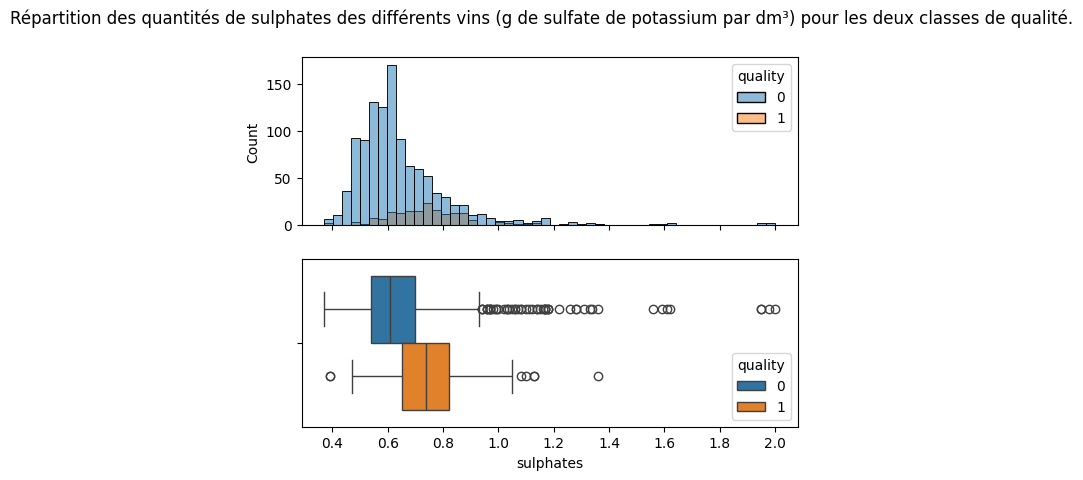

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
0,1109.0,0.647178,0.176122,0.37,0.54,0.61,0.70,2.00
1,170.0,0.743824,0.137957,0.39,0.65,0.74,0.82,1.36


In [601]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle(
    "Répartition des quantités de sulphates des différents vins (g de sulfate de potassium par dm³) pour les deux classes de qualité."
)
sns.histplot(data=train_set_binarisé, x="sulphates", hue="quality", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="sulphates", hue="quality", ax=ax[1])
plt.show()

train_set_binarisé.groupby("quality")["sulphates"].describe()

On observe que même si les deux classe de la targte sont superposé, on observe un décalage entre l'histogramme des bons vins par rapport à celui des mauvais vins. On observe des boxplot différents et les bons vin ont en moyenne une quantité de sulphates supérieur au mauvais vin.

In [602]:
print(
    "H0: La quantité de sulphate des bons vins est en moyenne identique à ceux des mauvais vins."
)

alpha = 0.02

p_value = ttest_ind(
    train_set_binarisé.query("`quality` == 1")["sulphates"],
    train_set_binarisé.query("`quality` == 0")["sulphates"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidences pour rejeter H0.")

H0: La quantité de sulphate des bons vins est en moyenne identique à ceux des mauvais vins.
Nous avons assez d'évidence pour rejeter H0.


Comme l'hypothése H0 à été rejeter, on peut sélectionner cette variable pour notre modéle.

## II.12) Alcool

### II.12.1) Analyse univarié

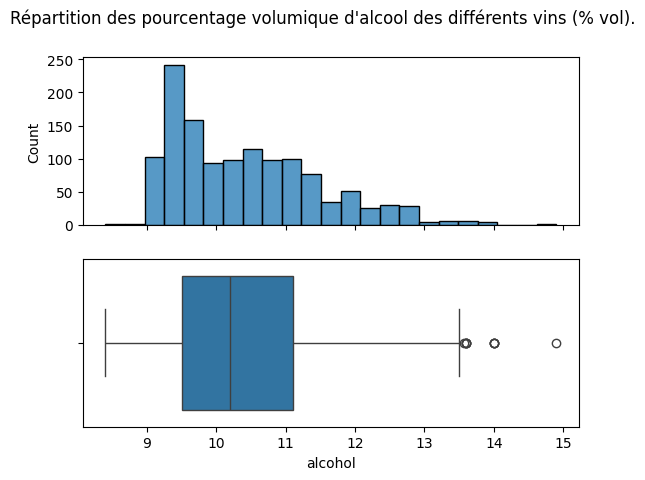

count    1279.000000
mean       10.418100
std         1.052694
min         8.400000
25%         9.500000
50%        10.200000
75%        11.100000
max        14.900000
Name: alcohol, dtype: float64

In [603]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle(
    "Répartition des pourcentage volumique d'alcool des différents vins (% vol)."
)
sns.histplot(data=train_set_binarisé, x="alcohol", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="alcohol", ax=ax[1])
plt.show()

train_set_binarisé["alcohol"].describe()

La moyenne de degré d'alcool des vins de ce dataset est de 10.418100 % vol. Cette variable suit une loi normale mais un peu déformé. On observe des outliers à droite de la boxplot.

### II.12.2) Analyse multivarié

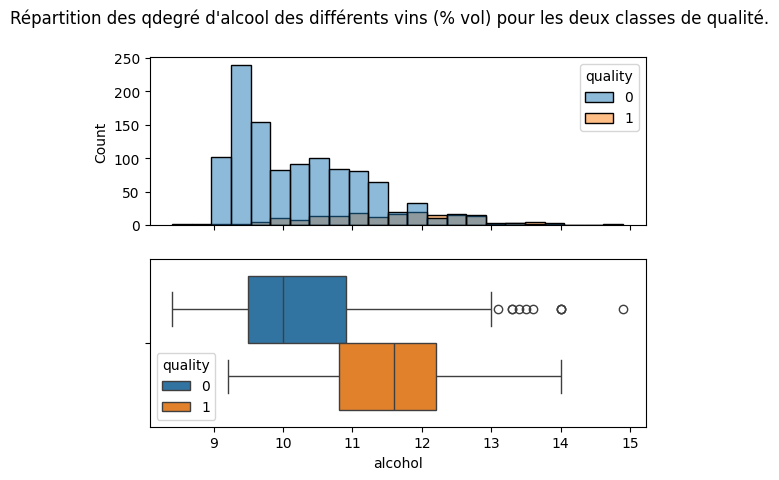

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
0,1109.0,10.250255,0.955540,8.4,9.5,10.0,10.9,14.9
1,170.0,11.513039,1.001522,9.2,10.8,11.6,12.2,14.0


In [604]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle(
    "Répartition des qdegré d'alcool des différents vins (% vol) pour les deux classes de qualité."
)
sns.histplot(data=train_set_binarisé, x="alcohol", hue="quality", ax=ax[0])
sns.boxplot(data=train_set_binarisé, x="alcohol", hue="quality", ax=ax[1])
plt.show()

train_set_binarisé.groupby("quality")["alcohol"].describe()

Même si il y a une superposition des deux histogrammes, on observe un décalage de l'histogramme des bons vin par rapport au mauvais. Par exemple, l'effectifs maximal des mauvais se situe entre 9 et 10 et les les bons vins à 12.

In [605]:
print(
    "H0: Le degré d'alcool des bons vins est en moyenne identique à ceux des mauvais vins."
)

alpha = 0.02

p_value = ttest_ind(
    train_set_binarisé.query("`quality` == 1")["alcohol"],
    train_set_binarisé.query("`quality` == 0")["alcohol"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidences pour rejeter H0.")

H0: Le degré d'alcool des bons vins est en moyenne identique à ceux des mauvais vins.
Nous avons assez d'évidence pour rejeter H0.


Comme on a rejeter H0, on peut utiliser cette variable aussi. En résumer seul le sel et le sucre résiduel ne permette pas de séparer les deux classes de la target. On va maintenant regarder les relations entre les variables entre-elles. Seules les meilleurs surfaces seront montrer.

# II.13) Analyse des relation entre les variable X entre-eux sur des surfaces 2D

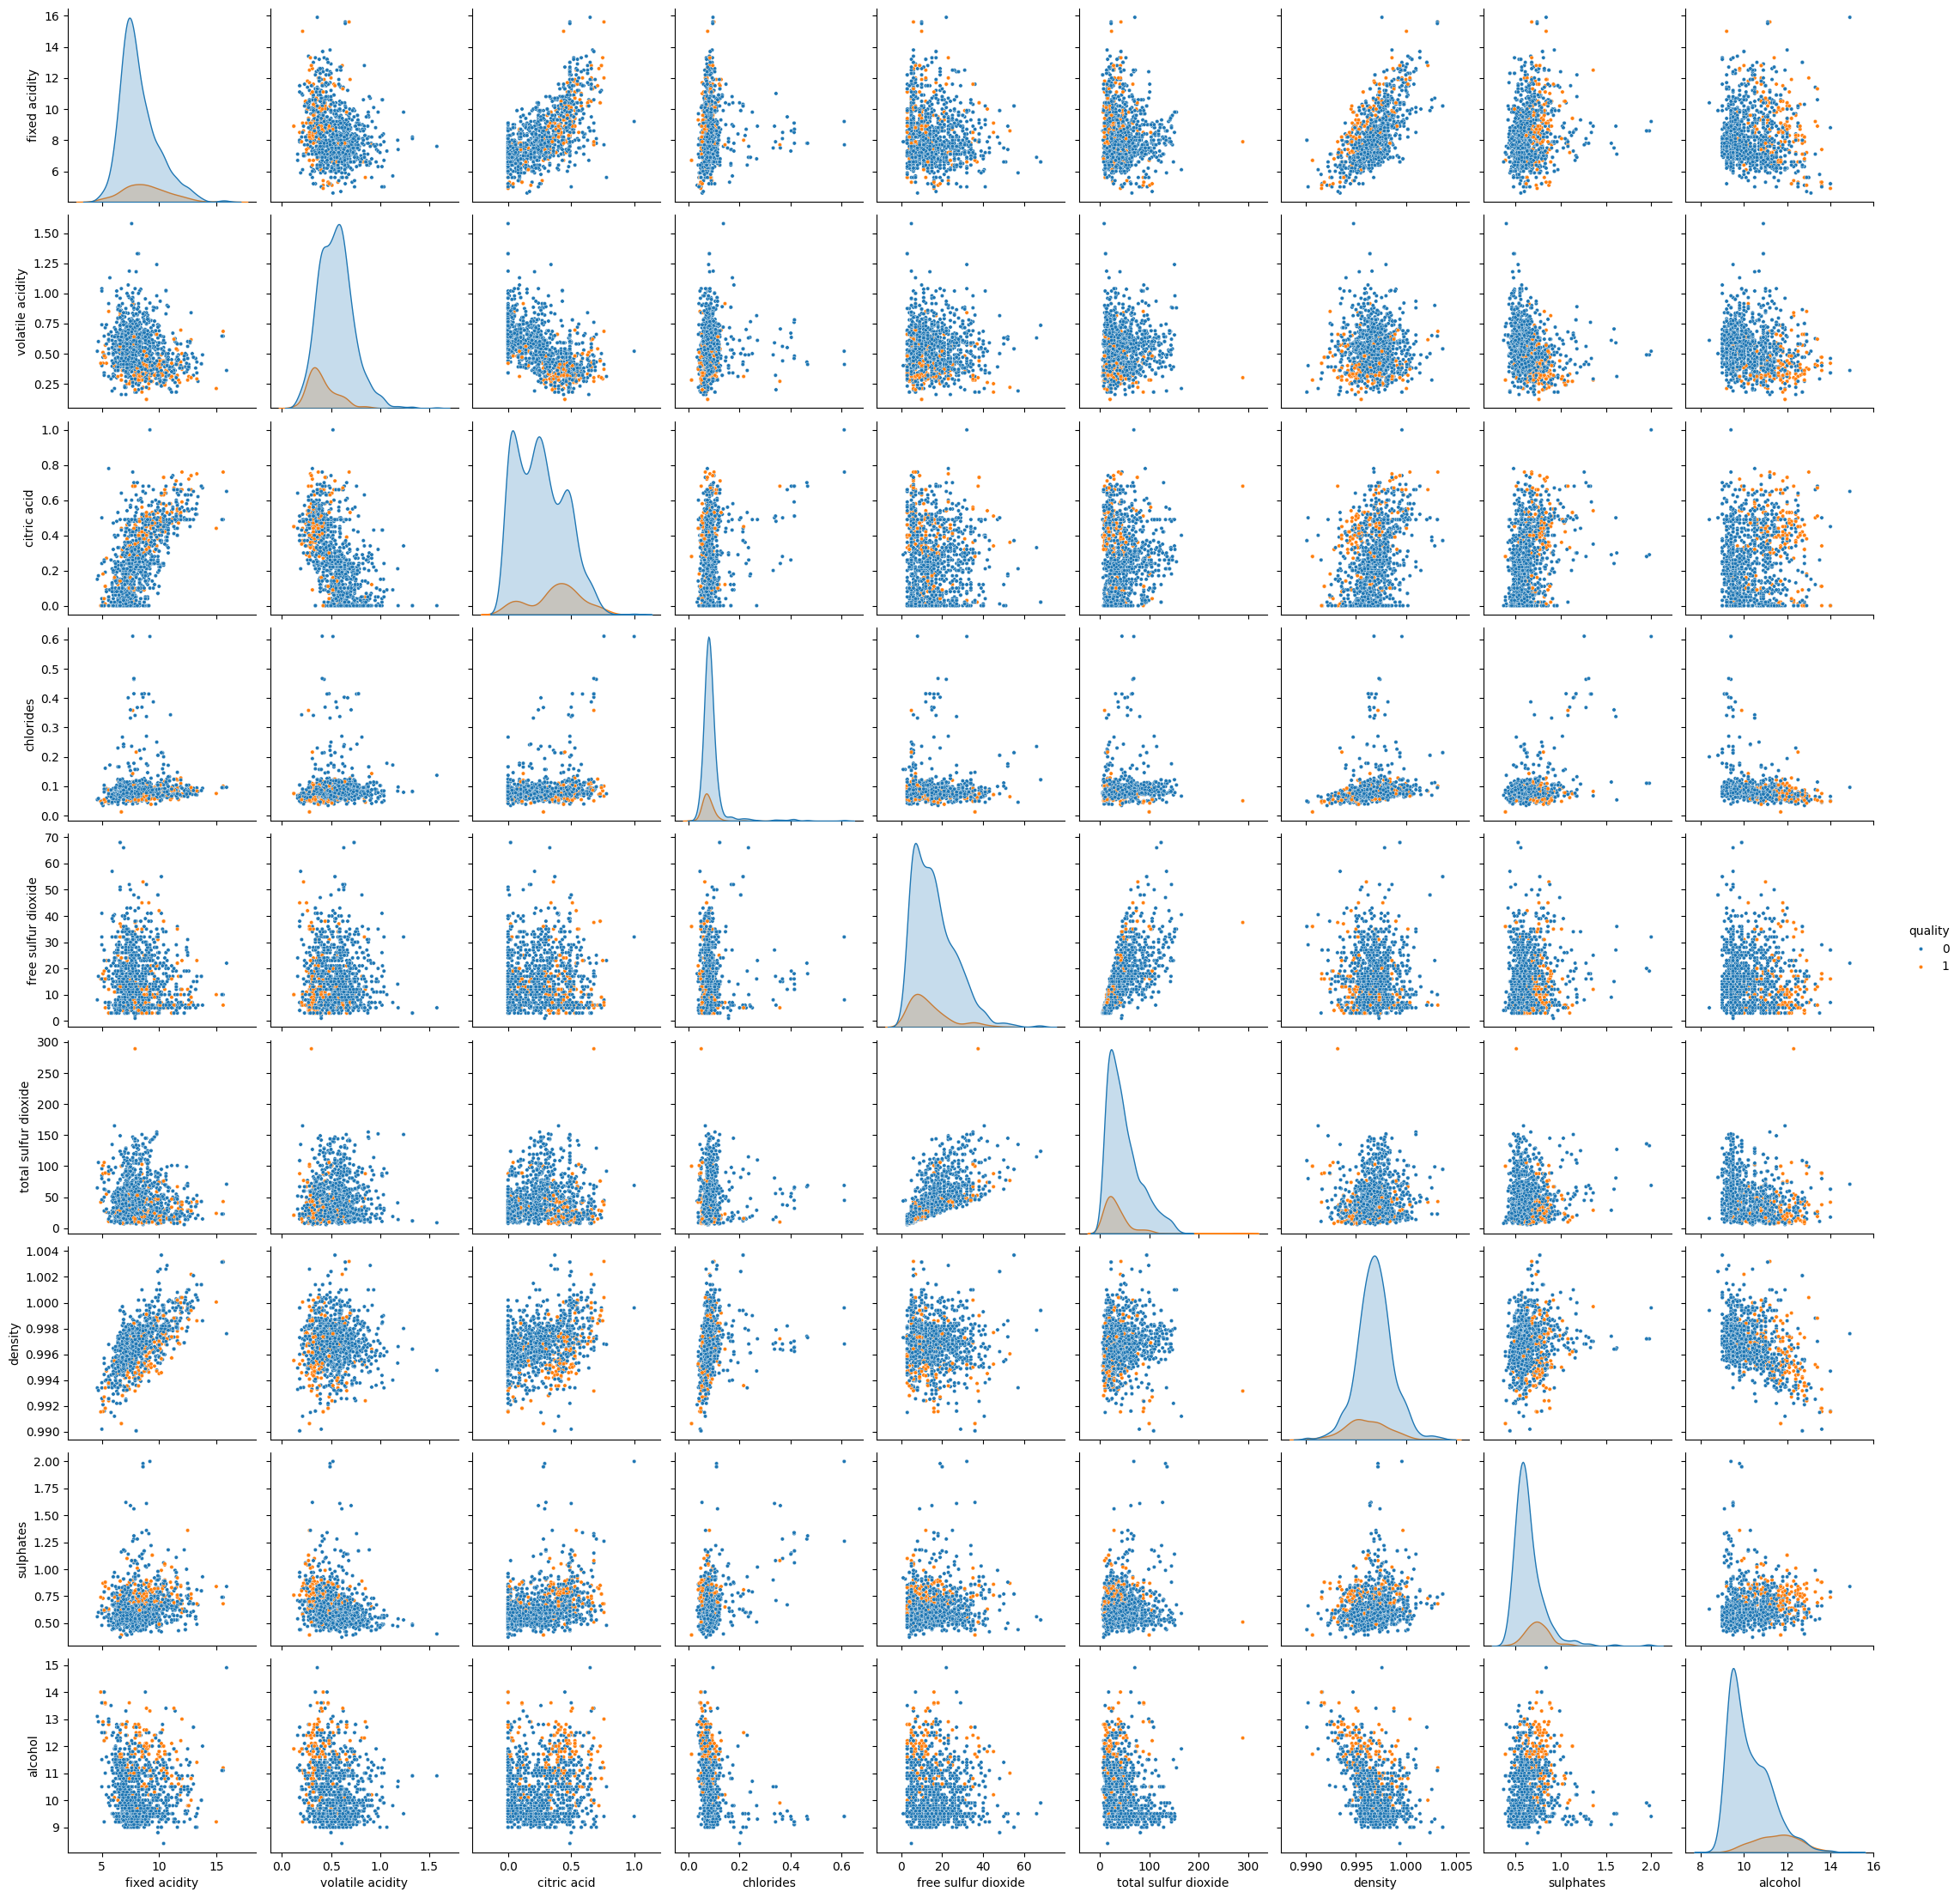

In [606]:
train_set_binarisé_copy = train_set_binarisé.copy()
train_set_binarisé_copy.drop(["residual sugar", "pH"], axis=1, inplace=True)

sns.pairplot(data=train_set_binarisé_copy, hue="quality", plot_kws={"s": 10})

On ne voit aucune surface vraiment séparable. On voit que les meilleurs surfaces sont les surfaces avec la quantité d'alcool et notamment avec les sulphates. On peut donc dire que la variables la plus importante pourrait être la quantité d'alcool. Maintenant on va essayer de faire un premier modéle avec l'alcool, les sulphates et l'acidité volatile. Avant de faire le modéle je vais visualiser ces trois variables sur un graphique 3D.

In [607]:
fig = px.scatter_3d(
    train_set_binarisé,
    x="sulphates",
    y="volatile acidity",
    z="alcohol",
    color="quality",
)
fig.update_traces(marker=dict(size=3))
fig.show()

On observe que cette surface permet une meilleur séparation des deux classes que les surfaces 2D. On va donc créer un premier modéle avec ces trois variable.

# III) Premier modéle

## III.1) Preprocessing

Comme il n'y a pas de variable catégoriel, il n'y aurat pas d'encoding. Il y aurat juste de la sélection de variable et de la normalisation. Pour tester la meilleur façon de normaliser, on va regarder l'effet des deux techniques de base, minmax et standardisation sur le graphique 3D.

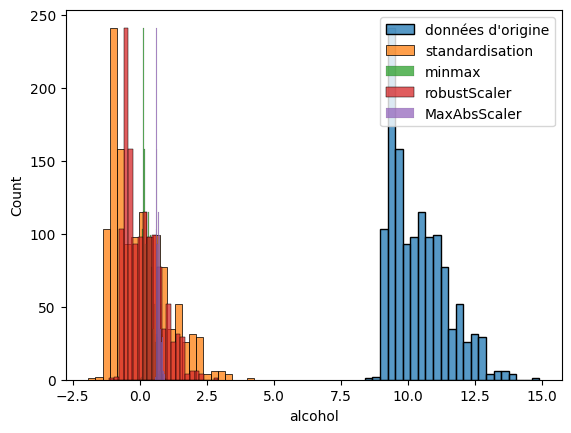

In [608]:
X_train = train_set_binarisé.drop("quality", axis=1)
y_train = train_set_binarisé["quality"]

standardizer = ColumnTransformer(
    [("standard", StandardScaler(), ["alcohol", "sulphates", "volatile acidity"])],
    verbose_feature_names_out=False,
)

minmaxer = ColumnTransformer(
    [("minmax", MinMaxScaler(), ["alcohol", "sulphates", "volatile acidity"])],
    verbose_feature_names_out=False,
)

robuster = ColumnTransformer(
    [("robust", RobustScaler(), ["alcohol", "sulphates", "volatile acidity"])],
    verbose_feature_names_out=False,
)

MaxAbser = ColumnTransformer(
    [("MaxAbser", MaxAbsScaler(), ["alcohol", "sulphates", "volatile acidity"])],
    verbose_feature_names_out=False,
)

X_std = standardizer.fit_transform(X_train)
X_minmax = minmaxer.fit_transform(X_train)
X_robust = robuster.fit_transform(X_train)
X_MaxAbs = MaxAbser.fit_transform(X_train)


sns.histplot(data=X_train, x="alcohol", label="données d'origine")
sns.histplot(data=X_std, x="alcohol", label="standardisation")
sns.histplot(data=X_minmax, x="alcohol", label="minmax")
sns.histplot(data=X_robust, x="alcohol", label="robustScaler")
sns.histplot(data=X_MaxAbs, x="alcohol", label="MaxAbsScaler")
plt.legend()
plt.show()

On voit que la standardisation serais la meilleur méthode pour l'alcool.

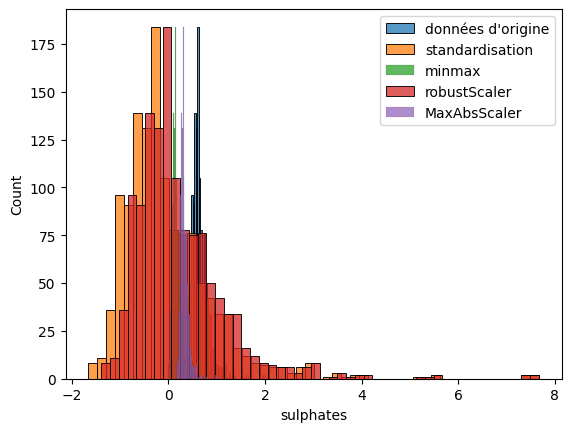

In [609]:
sns.histplot(data=X_train, x="sulphates", label="données d'origine")
sns.histplot(data=X_std, x="sulphates", label="standardisation")
sns.histplot(data=X_minmax, x="sulphates", label="minmax")
sns.histplot(data=X_robust, x="sulphates", label="robustScaler")
sns.histplot(data=X_MaxAbs, x="sulphates", label="MaxAbsScaler")
plt.legend()
plt.show()

Malgré un allure gaussienne, on voit que les standardisation et robustScaler donne un résultats pas terrible. Refaisons la figure sans ces deux méthodes.

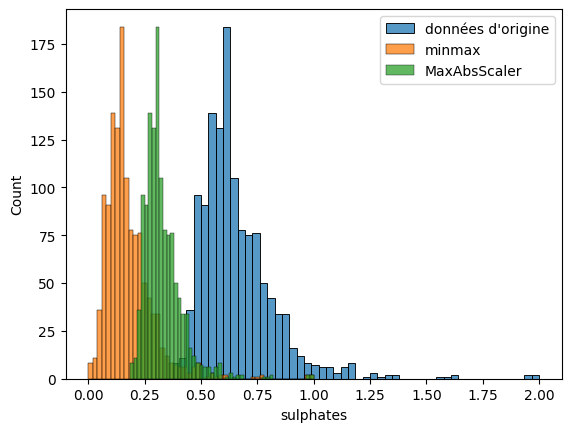

In [610]:
sns.histplot(data=X_train, x="sulphates", label="données d'origine")
sns.histplot(data=X_minmax, x="sulphates", label="minmax")
sns.histplot(data=X_MaxAbs, x="sulphates", label="MaxAbsScaler")
plt.legend()
plt.show()

On voit que le minMaxscaler compresse légéremment moins que le MaxAbsScaler. On va donc prendre le MinMaxScaler pour les sulphates.

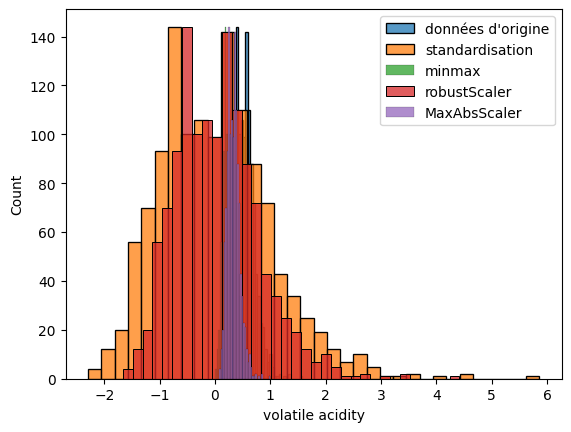

In [611]:
sns.histplot(data=X_train, x="volatile acidity", label="données d'origine")
sns.histplot(data=X_std, x="volatile acidity", label="standardisation")
sns.histplot(data=X_minmax, x="volatile acidity", label="minmax")
sns.histplot(data=X_robust, x="volatile acidity", label="robustScaler")
sns.histplot(data=X_MaxAbs, x="volatile acidity", label="MaxAbsScaler")
plt.legend()
plt.show()

Là encore les deux technique Robust et standard donne des résultats non satisfaisant. Regardons maintenant avec seulement les techniques minmax et maxabs.

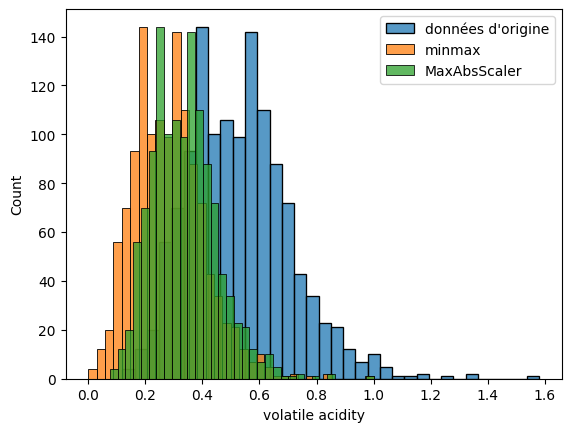

In [612]:
sns.histplot(data=X_train, x="volatile acidity", label="données d'origine")
sns.histplot(data=X_minmax, x="volatile acidity", label="minmax")
sns.histplot(data=X_MaxAbs, x="volatile acidity", label="MaxAbsScaler")
plt.legend()
plt.show()

On ne voit pratiquement aucune différences entre les deux méthodes. On voit tous de même que la solution minmax est de 0 à 1 et que le MaxAbs est aussi entre 0 et 1 mais cette méthode normalise de -1 à 1 donc on a seulement une petite partie qui est utiliser. Regardons le résultats finale sur le graphique 3D.

In [613]:
normalizer = ColumnTransformer(
    [
        ("standardizer", StandardScaler(), ["alcohol"]),
        ("minmax", MinMaxScaler(), ["sulphates", "volatile acidity"]),
    ],
    verbose_feature_names_out=False,
)

X_norm = normalizer.fit_transform(X_train)

fig = go.Figure()

# données d origine
fig.add_trace(
    go.Scatter3d(
        x=X_train["alcohol"],
        y=X_train["sulphates"],
        z=X_train["volatile acidity"],
        mode="markers",
        marker=dict(size=4),
        name="Données d'origine",
        visible=True,
    )
)

# StandardScaler
fig.add_trace(
    go.Scatter3d(
        x=X_norm["alcohol"],
        y=X_norm["sulphates"],
        z=X_norm["volatile acidity"],
        mode="markers",
        marker=dict(size=4),
        name="normalisé",
        visible=True,
    )
)
fig.show()

On observe une légére compression mais les deux nuages sont similaires ce qui montre qu'on peut utiliser ce normaliseur. Pour choisir un estimateur on va utiliser l'image si-dessous.
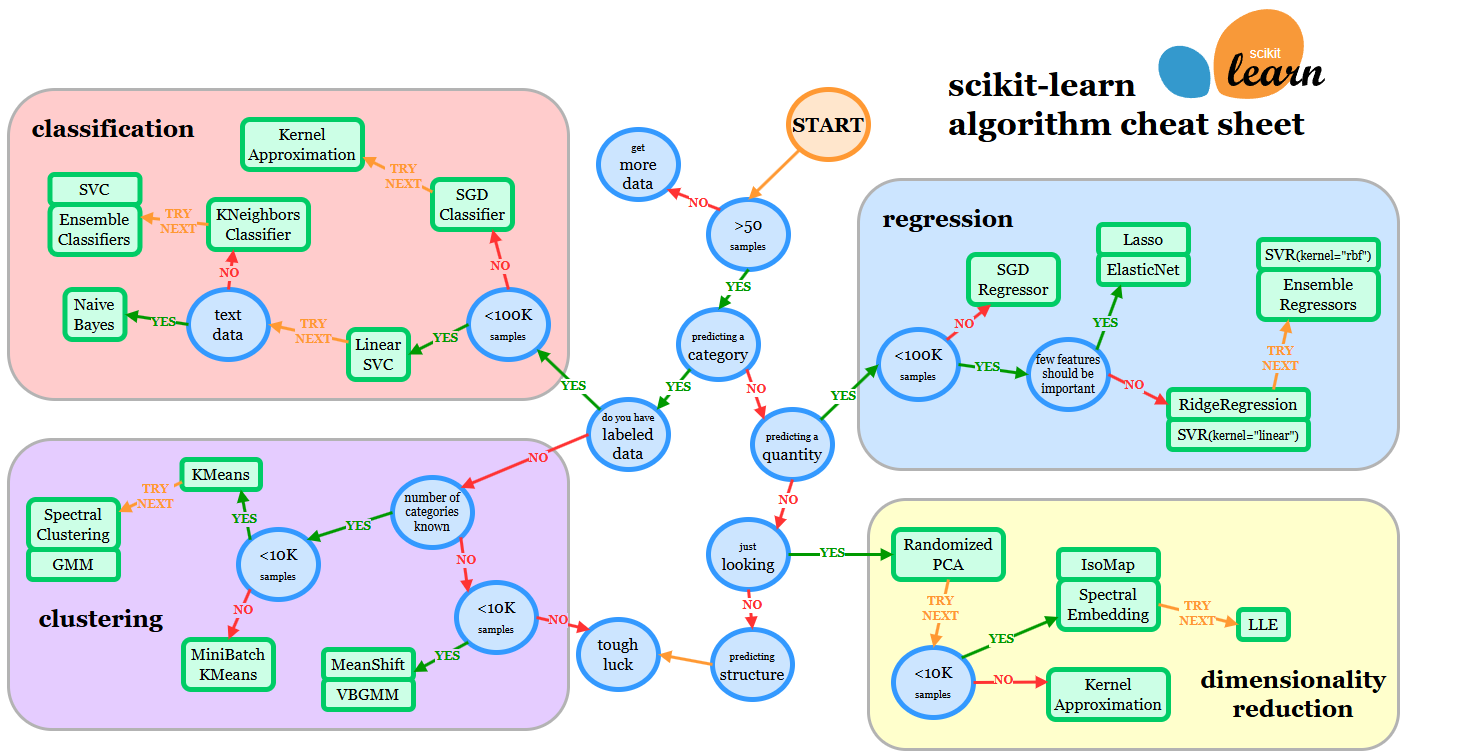

Si on regardes attentivement cette image on devrait tous d'abords utiliser un LinearSVC. Comme il y a un gros déséquilibre des deux classes on va utiliser un stratifiedKFold.

In [614]:
modelSVC = LinearSVC(random_state=42, class_weight="balanced")

paramSVC = {
    "penalty": ["l1", "l2"],
    "loss": ["hinge", "squared_hinge"],
    "multi_class": ["ovr", "crammer_singer"],
}

cv = StratifiedKFold(random_state=42, shuffle=True, n_splits=5)

gridSVC = GridSearchCV(
    modelSVC,
    cv=cv,
    param_grid=paramSVC,
    scoring="f1",
)

gridSVC.fit(X_norm, y_train)

print(gridSVC.best_params_)

print(gridSVC.best_score_)

print(gridSVC.score(X_norm, y_train))

{'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l1'}
0.48989681613297476
0.4920353982300885


/home/florian/WineQualityPrediction/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/florian/WineQualityPrediction/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/florian/WineQualityPrediction/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/florian/WineQualityPrediction/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/florian/WineQualityPrediction/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/florian/WineQualityPrediction/.venv/lib/python3.13/site-packages/skle

In [615]:
model = gridSVC.best_estimator_
test_set_binarisé = target_binarizer.transform(test_set)
X_test = test_set_binarisé.drop("quality", axis=1)
y_test = test_set_binarisé["quality"]
X_test_norm = normalizer.transform(X_test)
y_pred = model.predict(X_test_norm)
f1_score(y_pred, y_test)

0.5390070921985816

On obtient un score de 53% qui est insuffisant, on va donc tester un autre estimateurs. On va tester KnearestNeighborClassifier.

In [616]:
model_neighbor = KNeighborsClassifier(n_jobs=-1)

param_grid = {
    "n_neighbors": range(1, 101),
    "weights": ["uniform", "distance"],
    "p": [1, 2],
}

gridNeighbor = GridSearchCV(model_neighbor, cv=cv, param_grid=param_grid, scoring="f1")

gridNeighbor.fit(X_norm, y_train)

print(gridNeighbor.best_params_)

print(gridNeighbor.best_score_)

{'n_neighbors': 31, 'p': 1, 'weights': 'distance'}
0.5444091870276155


In [617]:
model = gridNeighbor.best_estimator_
test_set_binarisé = target_binarizer.transform(test_set)
X_test = test_set_binarisé.drop("quality", axis=1)
y_test = test_set_binarisé["quality"]
X_test_norm = normalizer.transform(X_test)
y_pred = model.predict(X_test_norm)
f1_score(y_pred, y_test)

0.5679012345679012

On a une amélioration du score mais elle reste insuffisant. Même si ce modéle n'est pas indiqué dans le chemin des choix des estimateurs on va tester un DecisionTreeClassifier car c'est un trés bon algorithme.

In [618]:
model_tree = DecisionTreeClassifier(random_state=42)

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 3, 5, 7, 10, 15],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "max_features": [None, "sqrt", "log2"],
    "class_weight": [None, "balanced"],
}

gridTree = GridSearchCV(model_tree, param_grid=param_grid, cv=cv, scoring="f1")

gridTree.fit(X_norm, y_train)

print(gridTree.best_params_)

print(gridTree.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
0.5324317955225233


In [619]:
model = gridTree.best_estimator_
test_set_binarisé = target_binarizer.transform(test_set)
X_test = test_set_binarisé.drop("quality", axis=1)
y_test = test_set_binarisé["quality"]
X_test_norm = normalizer.transform(X_test)
y_pred = model.predict(X_test_norm)
f1_score(y_pred, y_test)

0.5714285714285714

On voit que sur le jeu de test, l'arbre de décision donne une meilleur performance mais cela reste insuffisant. Comme l'algorithme de DecisionTreeClassifier à la meilleur performance sur le jeu de test, c'est cette algorithme qu'on va utiliser par la suite. On va maintenant utiliser toutes les variables dont on a réussie à rejeter H0 pour les tests de student. Avant de commencer la modélisation , on doit comme précédemment choisir la bonne méthode de normalisation.